C:\Users\frbla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\frbla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.025957948299979917
Number of non-zero weights: 4


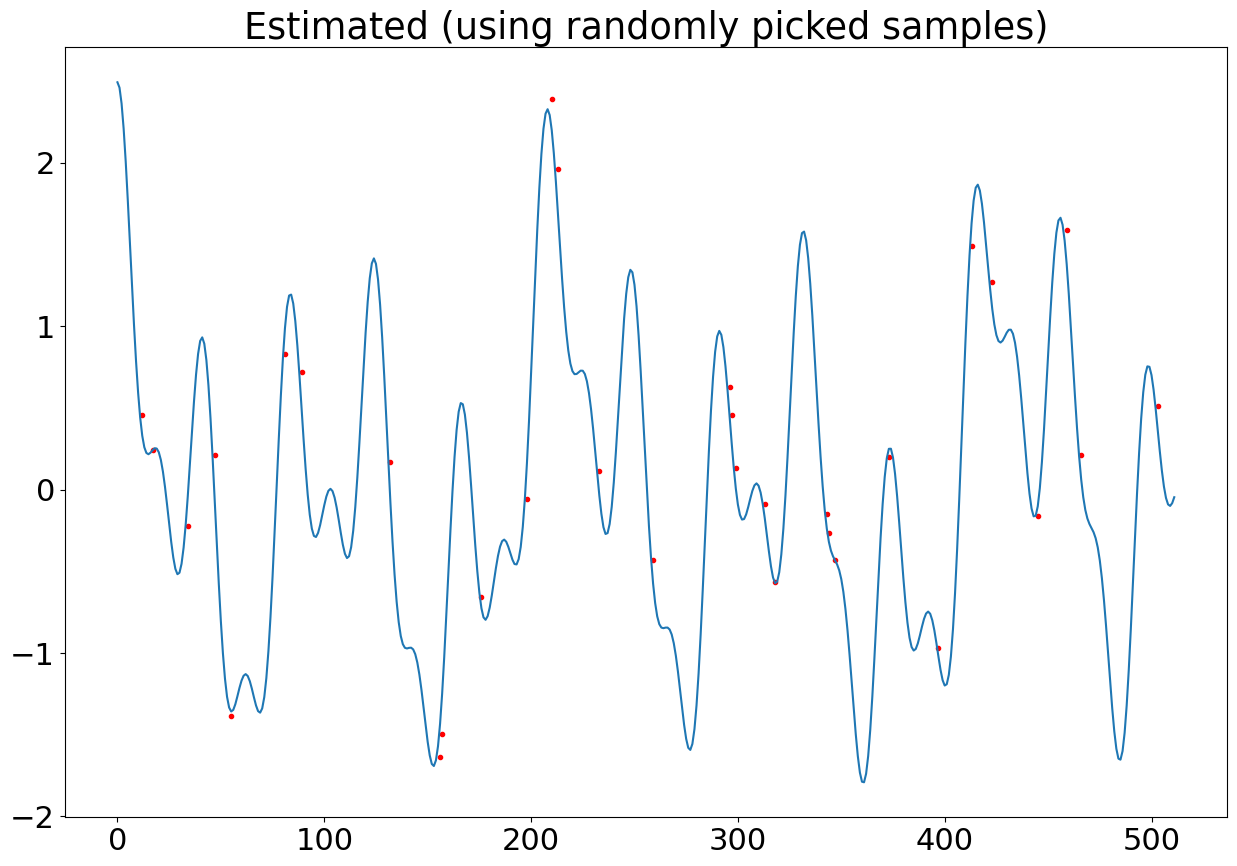

In [335]:
import librosa
import librosa.display
import IPython
import numpy as np
from scipy import linalg
from scipy import stats
import scipy.signal
from scipy.linalg import toeplitz
from scipy.signal import wiener
from scipy import signal
import matplotlib.pyplot as plt
import sounddevice as sd # only needed for playing
import soundfile as sf # only needed if playing does not work
from scipy.io import loadmat
from scipy import signal
from IPython.display import Audio
from scipy.fftpack import ifft, idct, dct
import math
from sklearn.linear_model import LassoLars, LassoLarsCV


problem= 'problem3_1'
matdata = loadmat(f'{problem}.mat')
n = matdata['n']
y = matdata['x']
l = 2**9;
N =len(y); 
# Construct the sensing matrix
B = np.zeros(shape=(N, l))
for i in range(0, N-1):
    B[i, n[i,:]-1] = 1

BF = idct(B, axis=1)  
# Use LassoLars
model = LassoLarsCV(fit_intercept=False, normalize=False,  max_iter=int(1e6))
model.fit(BF, y)
print(model.alpha_)
solsB = model.coef_
print(f'Number of non-zero weights: {np.count_nonzero(solsB)}')

# Take the inverse IDCT (i.e. the DCT) in order to compute the estimated signal.
x_hat = dct(solsB, axis=0)  

plt.figure(4, figsize=(15,10))
plt.plot(n, y, 'r.', label='Original signal')
plt.title('Original + Samples taken')
plt.plot(x_hat)
plt.title('Estimated (using randomly picked samples)')
plt.show()


[[0.21443841 1.        ]
 [0.00754782 0.50200458]]


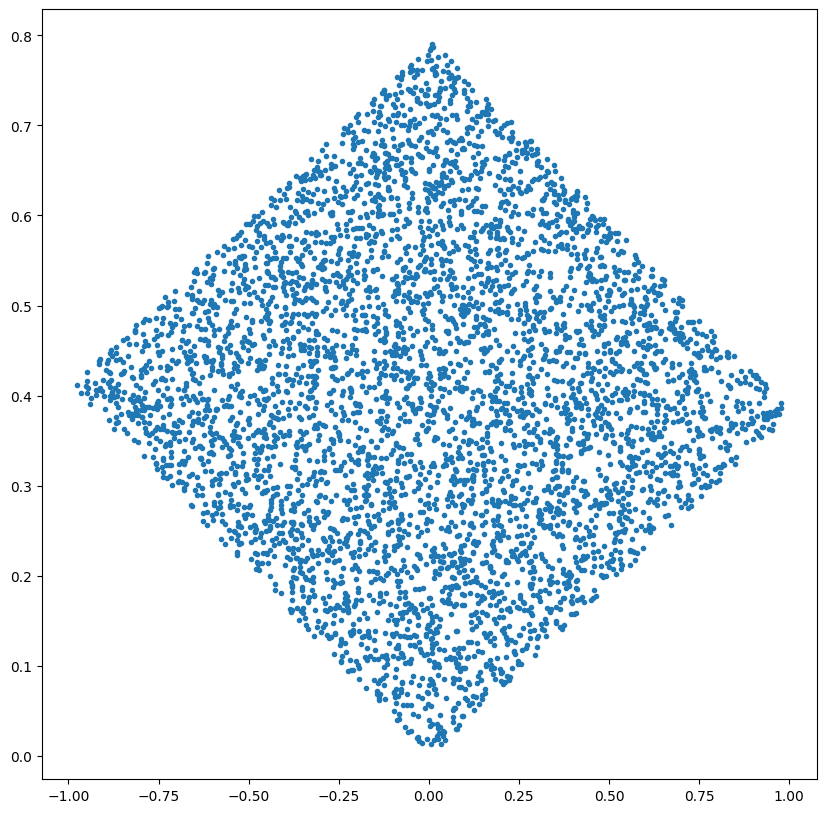

[[ 0.         -0.11889492]
 [ 0.16867125 -0.32578552]]


[[-0.02338716  0.5570723 ]
 [ 0.63049038  0.03184837]]


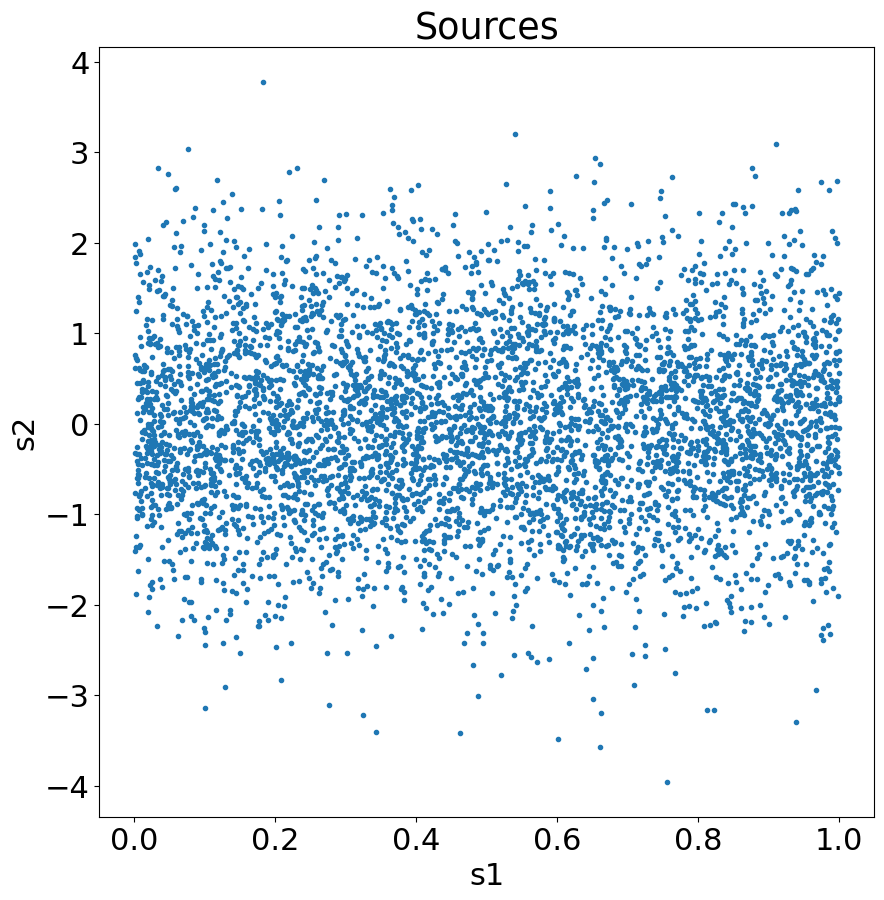

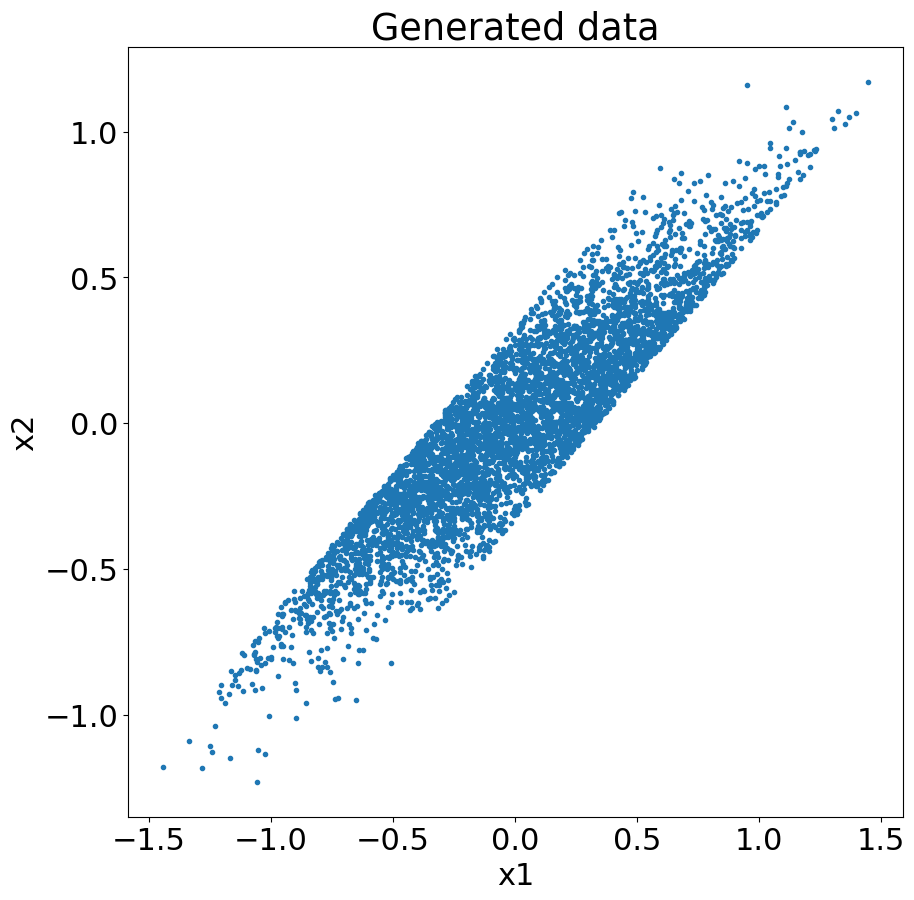

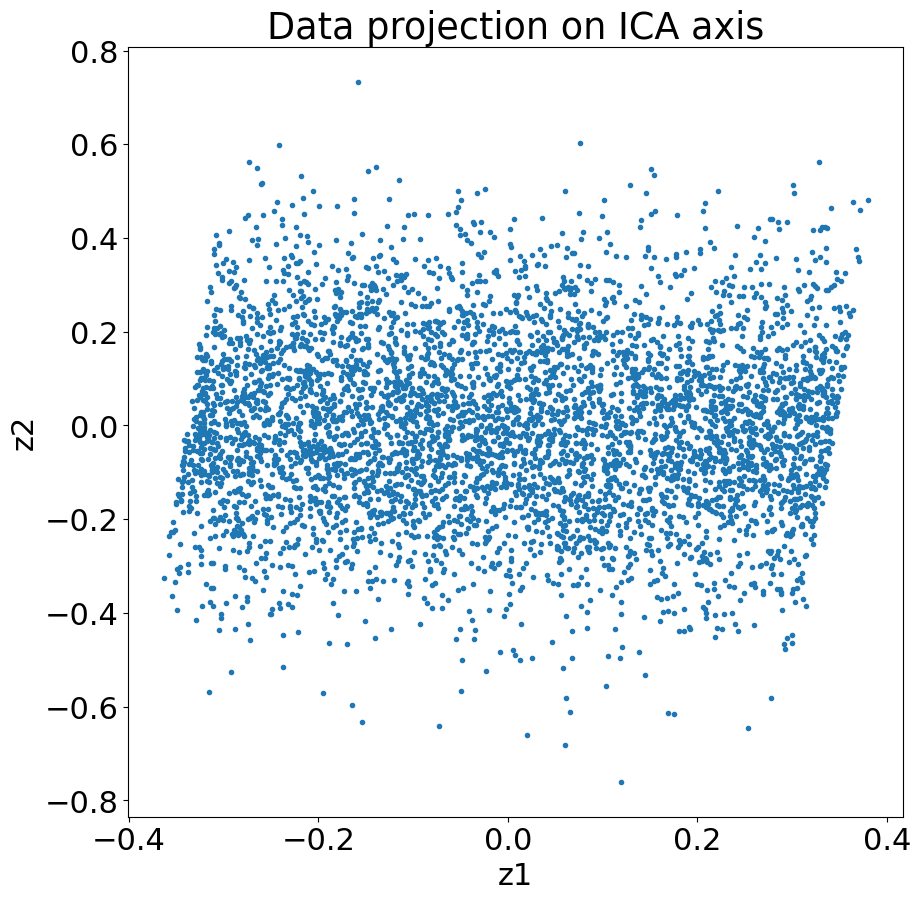

In [322]:
#plotting
plt.rcParams.update({'font.size': 22})
# generate data
N = 5000
A = [[3, 1], [1, 1]];
repetitions=100;
Amean = np.zeros(shape=(2,2))
case = 2;
for i in range(0,repetitions):
    if  case==0:
        # generate data with uniform distribution
        r = np.random.rand(N,2); 
    elif case==1:
        # generate data with uniform distribution and beta distribution
        r1 = np.random.rand(N,1); 
        r2 = np.random.beta(0.1,0.1,(N,1));   
        r = np.concatenate((r1,r2), axis=1); 
    elif case == 2:
         # generate data with uniform distribution and normal distribution
        r1 = np.random.rand(N,1); 
        r2 = np.random.normal(0,1,(N,1));
        r = np.concatenate((r1,r2), axis=1);
    elif case == 3:
        cov = [[2, 0.25], [0.25, 1]];
        mean= [0, 1];
        # generate data with uniform distribution
        r =np.random.multivariate_normal(mean, cov, size=N, check_valid='warn')
    
    else:
        # generate data with uniform distribution
        r = np.random.rand(N,2);


    
    x = (A@r.T).T;

    # calculate ica
    mu = 0.1;
    components = 2;
    iterations = 200;

    # Mean across the first (column) axis
    col_means = np.mean(x, axis=0)
    x = x - col_means

    # run ICA
    W = ICA(x, mu, components, iterations, 'subGauss')

    # Normalize unmixing matrix
    A= np.divide(A,np.max(A));
    W = np.divide(W, np.max(W))
    Ahat=np.linalg.inv(W);
    Ahat = np.divide(Ahat, np.max(Ahat));

    # Compute unmixed signals
    y = (W@x.T).T



    def ICAerror(Ahat,A):
        unmixinerror1=Ahat-A;
        unmixingerror2=np.fliplr(Ahat)-A;
        u=np.linalg.norm(unmixinerror1,'fro'); #Frobenius norm of the error matrix 
        k=np.linalg.norm(unmixingerror2,'fro'); #Frobenius norm of the error matrix
        if u<k:
            return unmixinerror1;   
        else:   
            return unmixingerror2;
     
    norm=ICAerror(Ahat,A)
    Amean=Amean+norm;   

Amean=Amean/repetitions;
print(Amean)

# plot sources
plt.figure(figsize=(10,10))
plt.plot(r[:,0],r[:,1],'.')
plt.title('Sources')
plt.ylabel('s2')
plt.xlabel('s1')
plt.show()

# plot generated data
plt.figure(figsize=(10,10))
plt.plot(x[:,0],x[:,1],'.')
plt.title('Generated data')
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

# plot data projection on ica axis
plt.figure(figsize=(10,10))
plt.title('Data projection on ICA axis')
plt.plot(y[:,0],y[:,1],'.')
plt.ylabel('z2')
plt.xlabel('z1')
plt.show()



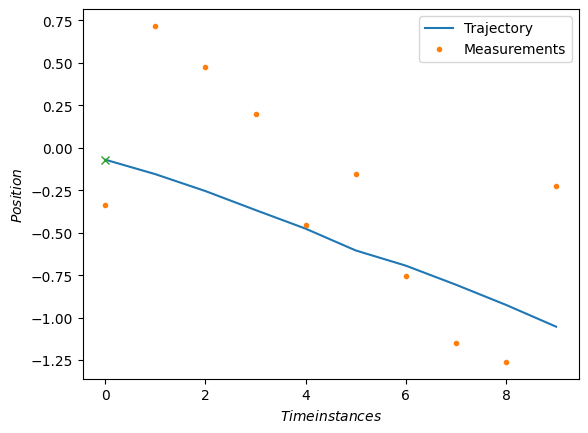

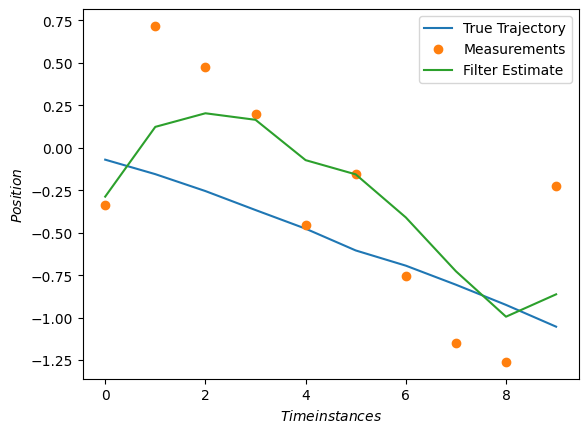

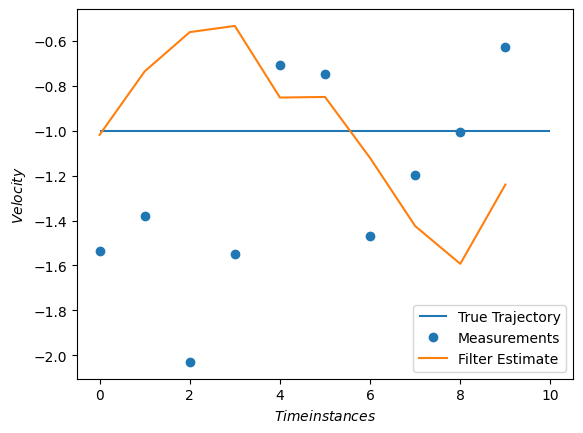

In [262]:
import numpy as np
import matplotlib.pyplot as plt


# Set the parameters

q = 1
dt = 0.1
s = 0.5
k=dt**3/3
alpha = 0.01;
A = np.array([
    [1, dt,],
    [0, 1,]
])
Q = q*np.array([
    [k, alpha],
    [0,  k]
])

H = np.array([
    [1, 0],
    [0, 0]])
R = s**2*np.identity(2)
m0 = np.array([[0], [-1]])
P0 = np.identity(2)

# Simulate data

np.random.seed(1)

steps = 10
X = np.zeros((len(A), steps))
Y = np.zeros((len(H), steps))
x = m0
for k in range(steps):
    q = np.linalg.cholesky(Q)@np.random.randn(len(A), 1)
    x = A@x + q
    y = H@x + s*np.random.randn(2, 1)
    X[:, k] = x[:, 0]
    Y[:, k] = y[:, 0]

plt.figure()
plt.plot(X[0, :], '-')
plt.plot(Y[0, :], '.')
plt.plot(X[0, 0], 'x')
plt.legend(['Trajectory', 'Measurements'])
plt.xlabel('$Time instances$')
plt.ylabel('$Position$')


# Kalman filter

m = m0
P = P0
kf_m = np.zeros((len(m), Y.shape[1]))
kf_P = np.zeros((len(P), P.shape[1], Y.shape[1]))
for k in range(Y.shape[1]):
    m = A@m
    P = A@P@A.T + Q

    v = Y[:, k].reshape(-1, 1) - H@m
    S = H@P@H.T + R
    K = P@H.T@np.linalg.inv(S)
    m = m + K@v
    P = P - K@S@K.T

    kf_m[:, k] = m[:, 0]
    kf_P[:, :, k] = P

rmse_raw = np.sqrt(np.mean(np.sum((Y - X[:2, :])**2, 1)))
rmse_kf = np.sqrt(np.mean(np.sum((kf_m[:2, :] - X[:2, :])**2, 1)))

plt.figure()
plt.plot(X[0, :], '-')
plt.plot(Y[0, :], 'o')
plt.plot(kf_m[0, :], '-')
plt.legend(['True Trajectory', 'Measurements', 'Filter Estimate'])
plt.xlabel('$Time instances$')
plt.ylabel('$Position$')

plt.show()


plt.figure()
#plt.plot(X[1, :], '-')
plt.hlines(m0[1],0,steps,label='True velocity')
plt.plot(m0[1] + Y[1, :], 'o')
plt.plot(kf_m[1, :], '-')

plt.legend(['True Trajectory', 'Measurements', 'Filter Estimate'])
plt.xlabel('$Time instances$')
plt.ylabel('$Velocity$')

plt.show()


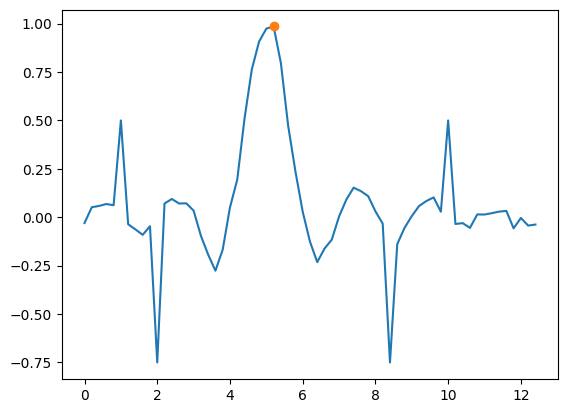

5.2


5.0


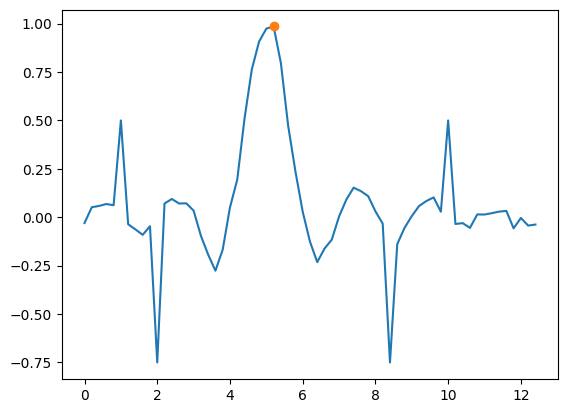

5.2


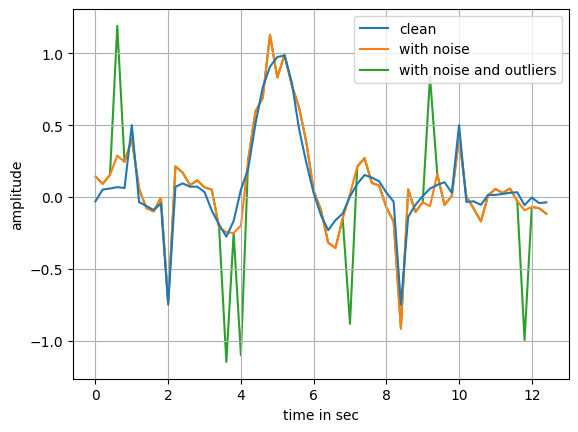

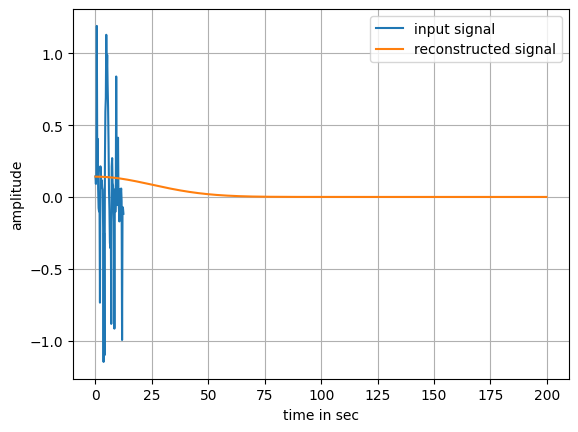

In [290]:
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

problem= 'problem3_6'
matdata = loadmat(f'{problem}.mat')
y = matdata['y'].squeeze()
x = matdata['t'].squeeze()
fs=1/(x[1] - x[0])
print(fs)
plt.plot(x.T,y.T)

max=np.max(y)
nmax=np.argmax(y)
plt.plot(x[nmax],max,'o')
plt.show()
print(x[nmax])

# data parameters
np.random.seed(0)
N = len(y)
samples = 1000
percent_outlier = 0.1
snr = 10  # dB

# learning parameters
sigma = 0.004
C = 1e-2

# init figure
fig, ax = plt.subplots()

# load bladerunner data
#indices = np.arange(0, samples, samples//N)
#start = 100000
#sound, fs = sf.read(os.path.join(r'C:\Users\frbla\OneDrive\Development\Engineering Acoustics\Courses\Machine Learning for Signal Processing\02471-e23\exercises\week12\python\data', 'BladeRunner.wav'), frames=samples, start=start)
#y = sound[indices, 0]
Ts = 1/fs  # sampling period
t1 = np.arange(samples)*Ts  # the times of sampling
#x = t[indices]
ax.plot(x, y, label='clean', zorder=2)

# add white Gaussian noise
noise = np.random.randn(N)
noise *= (np.sum(y**2)/np.sum(noise**2)/10**(snr/10))**0.5
y += noise
ax.plot(x, y, label='with noise', zorder=1)

# add outliers
amp = 0.8*np.max(abs(y))
M = np.floor(percent_outlier*N).astype(int)
out_ind = np.random.choice(N, M)
outs = np.sign(np.random.randn(M))*amp
y[out_ind] += outs
ax.plot(x, y, label='with noise and outliers', zorder=0)

# finish figure
ax.set_xlabel('time in sec')
ax.set_ylabel('amplitude')
ax.legend()
ax.grid()

# unbiased L2 Kernel Ridge Regression (KRR-L2)
# build kernel matrix
pair_dist = np.abs(x.reshape(-1, 1) - x.reshape(1, -1)) # solution  
K = np.exp(-1/(sigma**2)*pair_dist**2) # solution  
A = C*np.identity(N) + K # solution  
sol = np.linalg.solve(A, y)

# Generate regressor
# NOTE: this loop can be optimized
z0 = np.zeros(samples)
for k in range(samples):
    z0[k] = 0
    for j in range(N):
        value = np.exp(-1/(sigma**2)*(x[j] - t[k])**2)
        z0[k] += sol[j]*value

# plot
fig, ax = plt.subplots()
ax.set_xlabel('time in sec')
ax.set_ylabel('amplitude')
ax.plot(x, y, label='input signal')
ax.plot(t1, z0, label='reconstructed signal')
ax.legend()
ax.grid()